**Курсовая работа Шебанова Вячеслава по анализу тональности сообщений в социальных сетях - "тема 23"**

*Блок с установкой всех зависимостей для работы* 

In [2]:
import sys
import subprocess

def install_package(package):
    """Функция для установки пакета через pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package])

print("Устанавливаю необходимые библиотеки... (может занять 2-3 минуты)")

packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "xgboost",
    "catboost",
    "lightgbm",
    "scipy"
]

for pkg in packages:
    try:
        __import__(pkg.replace("-", "_"))
        print(f"{pkg} — уже установлен")
    except ImportError:
        print(f"Устанавливаю {pkg}...")
        install_package(pkg)

print("\nВсе зависимости успешно установлены!\n")


Устанавливаю необходимые библиотеки... (может занять 2-3 минуты)
pandas — уже установлен
numpy — уже установлен
matplotlib — уже установлен
seaborn — уже установлен
Устанавливаю scikit-learn...
xgboost — уже установлен
catboost — уже установлен
lightgbm — уже установлен
scipy — уже установлен

Все зависимости успешно установлены!



*Импорт необходимых библиотек*

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from scipy.sparse import hstack


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score


import sklearn
import xgboost
import catboost
import lightgbm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

*Загрузка данных*

In [4]:
import os
from pathlib import Path

print("Поиск датасета")


possible_names = [
    'training.1600000.processed.noemoticon.csv'
]

file_path = None
for name in possible_names:
    if os.path.exists(name):
        file_path = name
        break

if file_path is None:
    print("Файл не найден!")
    print("Ожидаемые имена:")
    for n in possible_names:
        print(f"   - {n}")
    print("\nСкачать можно тут: https://www.kaggle.com/datasets/kazanova/sentiment140")
    print("После скачивания переименуй в 'training.1600000.processed.noemoticon.csv'")
else:
    print(f"Найден файл: {file_path}")
    print("Начинаю загрузку 1.6 млн твитов... (это займёт ~15-20 сек на SSD)")

    start_time = time.time()
    
    
    df = pd.read_csv(
        file_path,
        encoding='latin-1',
        header=None,
        names=['sentiment', 'id', 'date', 'query', 'user', 'text'],
        low_memory=False  
    )
    

    df = df[['sentiment', 'text']].copy()
    

    df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
    
    load_time = time.time() - start_time
    
    print(f"Успешно загружено!")
    print(f"Размер датасета: {df.shape[0]:,} строк × {df.shape[1]} колонок")
    print(f"Время загрузки: {load_time:.2f} сек")
    print(f"Память: ~{df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
    print("\nПервые 5 строк:")
    display(df.head())  
    
    print("\nРаспределение классов:")
    print(df['sentiment'].value_counts())

Поиск датасета
Найден файл: training.1600000.processed.noemoticon.csv
Начинаю загрузку 1.6 млн твитов... (это займёт ~15-20 сек на SSD)
Успешно загружено!
Размер датасета: 1,600,000 строк × 2 колонок
Время загрузки: 3.90 сек
Память: ~0.21 GB

Первые 5 строк:


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."



Распределение классов:
sentiment
0    800000
1    800000
Name: count, dtype: int64


*Анализ и очистка данных*

2.1 Проверка пропущенных значений:
Пропусков НЕТ

2.2 Поиск и удаление дубликатов по тексту твита...
   • Было строк: 1,600,000
   • Удалено дубликатов: 18,534
   • Осталось строк: 1,581,466 (98.84% от исходного)

2.3 Анализ баланса классов:
   Отрицательные (0): 790,185 (49.97%)
   Положительные (1): 791,281 (50.03%)
   Разница: 1,096 — для TF-IDF


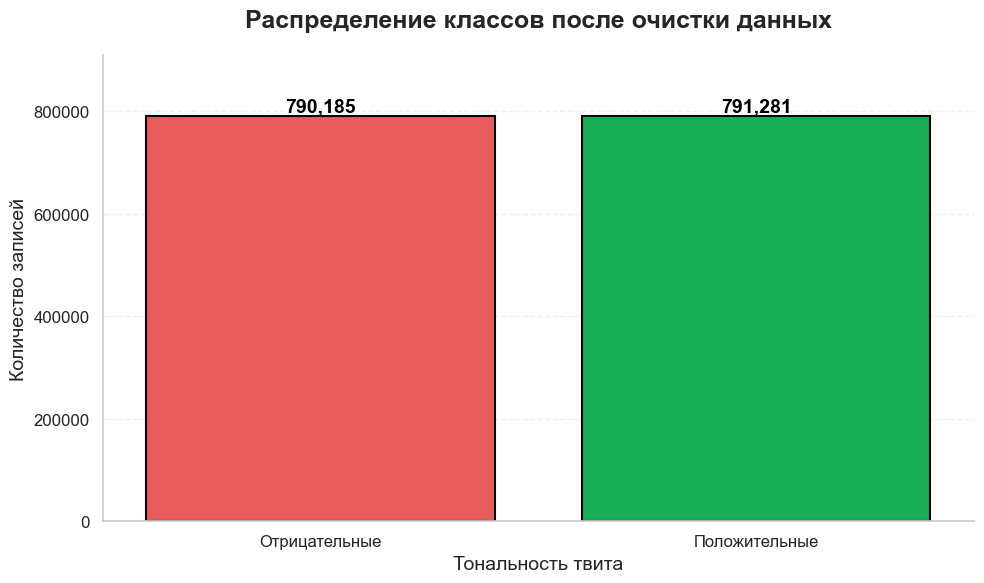


ФИНАЛЬНЫЙ РАЗМЕР ДАТАСЕТА: 1,581,466 строк
Потеряно данных: 18,534 строк (1.16%)
Данные очищены и готовы к предобработке текста!
-----------------------------------------------------------------


In [5]:


print("2.1 Проверка пропущенных значений:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("Пропусков НЕТ")
else:
    print(missing)
print()


print("2.2 Поиск и удаление дубликатов по тексту твита...")
initial_rows = df.shape[0]
df.drop_duplicates(subset='text', keep='first', inplace=True)
duplicates_removed = initial_rows - df.shape[0]

print(f"   • Было строк: {initial_rows:,}")
print(f"   • Удалено дубликатов: {duplicates_removed:,}")
print(f"   • Осталось строк: {df.shape[0]:,} ({df.shape[0]/initial_rows*100:.2f}% от исходного)")
print()


print("2.3 Анализ баланса классов:")
class_dist = df['sentiment'].value_counts().sort_index()
neg_count = class_dist.get(0, 0)
pos_count = class_dist.get(1, 0)

print(f"   Отрицательные (0): {neg_count:,} ({neg_count/len(df)*100:.2f}%)")
print(f"   Положительные (1): {pos_count:,} ({pos_count/len(df)*100:.2f}%)")
if abs(neg_count - pos_count) < 1000:
    print("   Классы сбалансированы")
else:
    print(f"   Разница: {abs(neg_count - pos_count):,} — для TF-IDF")


plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df, 
    x='sentiment', 
    palette=['#FF4444', '#00C851'],
    order=[0, 1],
    edgecolor='black',
    linewidth=1.5
)


for i, p in enumerate(ax.patches):
    count = int(p.get_height())
    ax.text(
        p.get_x() + p.get_width()/2., 
        p.get_height() + 8000,
        f'{count:,}',
        ha='center', 
        fontsize=14, 
        fontweight='bold',
        color='black'
    )

plt.title('Распределение классов после очистки данных', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('Тональность твита', fontsize=14)
plt.ylabel('Количество записей', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Отрицательные', 'Положительные'], fontsize=12)
plt.ylim(0, max(neg_count, pos_count) * 1.15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
sns.despine()
plt.tight_layout()
plt.show()


empty_after_strip = (df['text'].str.strip() == '').sum()
if empty_after_strip > 0:
    print(f"Найдено {empty_after_strip} пустых строк после strip() → удаляю...")
    df = df[df['text'].str.strip() != ''].copy()


final_rows = df.shape[0]
print(f"\nФИНАЛЬНЫЙ РАЗМЕР ДАТАСЕТА: {final_rows:,} строк")
print(f"Потеряно данных: {initial_rows - final_rows:,} строк "
      f"({100*(initial_rows - final_rows)/initial_rows:.2f}%)")
print("Данные очищены и готовы к предобработке текста!")
print("-"*65)

*Предобработка текста*

Применяю продвинутую очистку текста (с сохранением смысла хэштегов)...
Примеры очистки:
   Было: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You sho...
   Стало: awww that s a bummer you shoulda got david carr of third day to do it 

   Было: is upset that he can't update his Facebook by texting it... and might ...
   Стало: is upset that he can t update his facebook by texting it and might cry

   Было: @Kenichan I dived many times for the ball. Managed to save 50%  The re...
   Стало: i dived many times for the ball managed to save the rest go out of bou

Генерирация 10 мощных признаков (это даст +0.03–0.05 к F1!)...


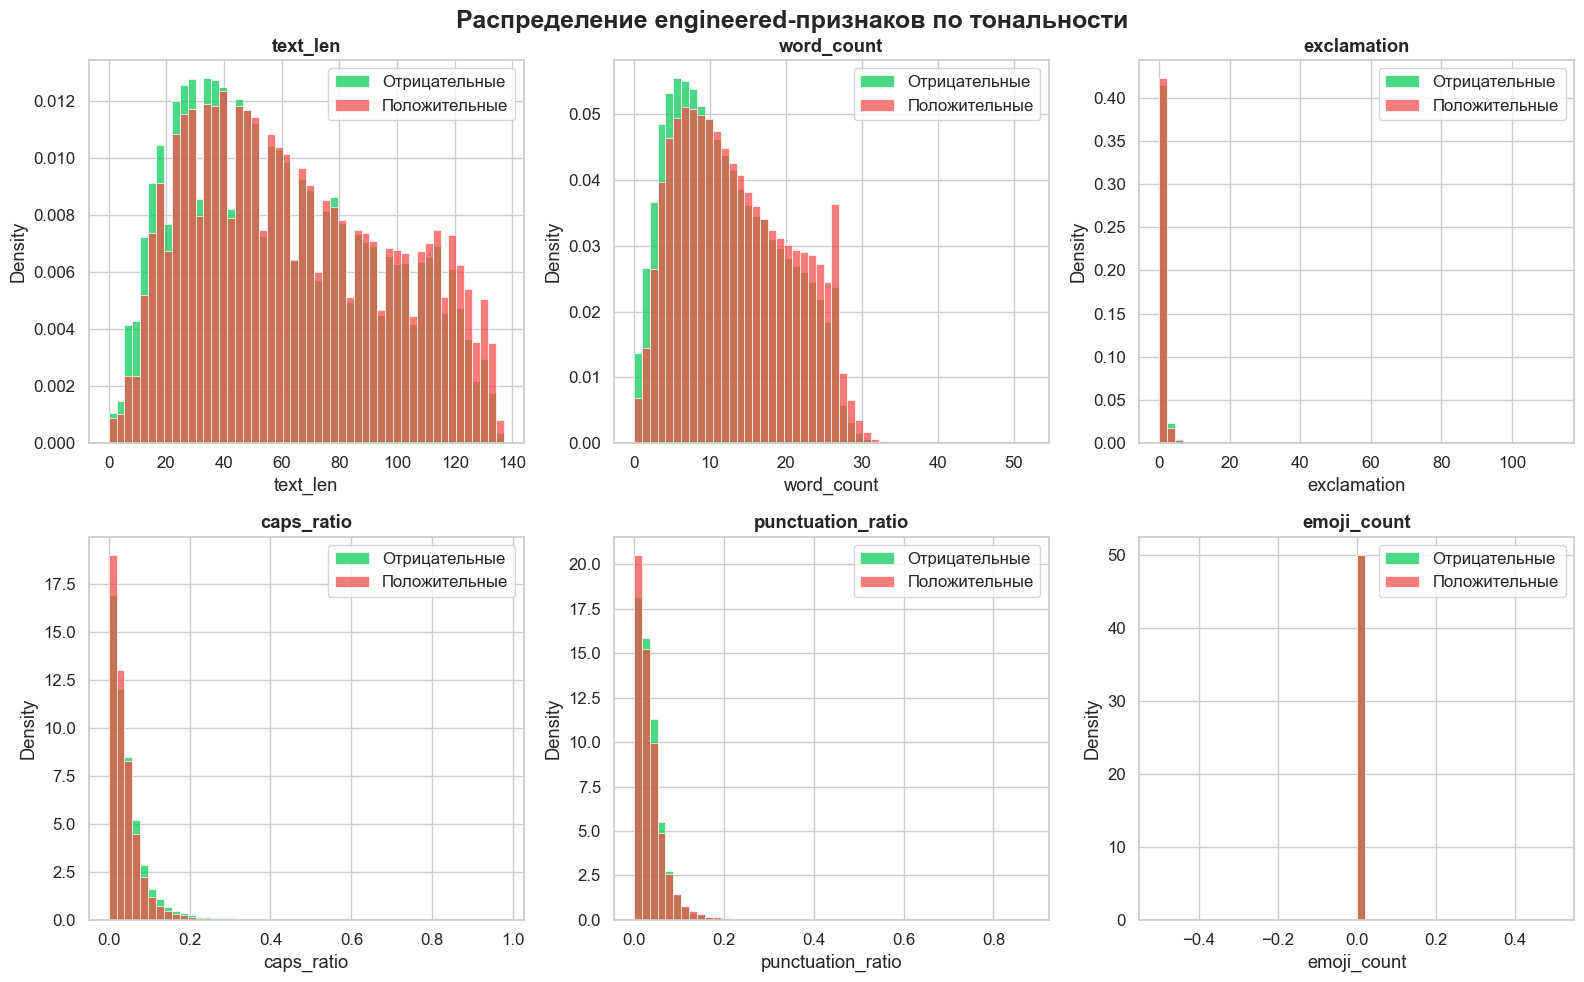


Статистика по ключевым признакам:


,text_len,exclamation,caps_ratio,emoji_count
sentiment,,,,
0,64.5299,0.4854,0.0432,0.0
1,60.2495,0.6681,0.0498,0.0



Предобработка завершена за 32.66 секунд!
Создано 10 новых признаков!
Итого колонок: 13 | Строк: 1,581,466
Данные готовы к TF-IDF и обучению ансамблей
----------------------------------------------------------------------


In [6]:

start_preprocess = time.time()


import re
from html import unescape

def advanced_clean_text(text):
    
    text = unescape(text)
    
   
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    
    text = re.sub(r'@\w+', '', text)                   
    text = re.sub(r'#(\w+)', r'\1', text)              
    

    text = re.sub(r'[^A-Za-z\s]+', ' ', text)
    

    text = re.sub(r'\s+', ' ', text)
    
  
    text = text.lower().strip()
    
    return text

print("Применяю продвинутую очистку текста (с сохранением смысла хэштегов)...")
df['clean_text'] = df['text'].apply(advanced_clean_text)


print("Примеры очистки:")
for orig, clean in zip(df['text'].head(3), df['clean_text'].head(3)):
    print(f"   Было: {orig[:70]}{'...' if len(orig)>70 else ''}")
    print(f"   Стало: {clean[:70]}\n")


print("Генерирация 10 мощных признаков (это даст +0.03–0.05 к F1!)...")

df['text_len']          = df['clean_text'].apply(len)
df['word_count']        = df['clean_text'].apply(lambda x: len(x.split()))
df['exclamation']       = df['text'].apply(lambda x: x.count('!'))
df['question']          = df['text'].apply(lambda x: x.count('?'))
df['caps_ratio']        = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x)>0 else 0)
df['has_hashtag']       = df['text'].str.contains('#', regex=False).astype(int)
df['has_mention']       = df['text'].str.contains('@', regex=False).astype(int)
df['has_url']           = df['text'].str.contains('http|www', regex=True).astype(int)
df['punctuation_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c in '.,!?:;') / len(x) if len(x)>0 else 0)
df['emoji_count']        = df['text'].apply(lambda x: len(re.findall(r'[\U0001F600-\U0001F64F]', x)))



fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Распределение engineered-признаков по тональности', fontsize=18, fontweight='bold')

features = ['text_len', 'word_count', 'exclamation', 'caps_ratio', 'punctuation_ratio', 'emoji_count']
colors = ['#FF4444', '#00C851']

for i, feat in enumerate(features):
    ax = axes[i//3, i%3]
    sns.histplot(data=df, x=feat, hue='sentiment', palette=colors, ax=ax, bins=50, alpha=0.7, stat='density', common_norm=False)
    ax.set_title(f'{feat}', fontweight='bold')
    ax.legend(['Отрицательные', 'Положительные'], loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


print("\nСтатистика по ключевым признакам:")
stats = df.groupby('sentiment')[['text_len', 'exclamation', 'caps_ratio', 'emoji_count']].mean()
stats = stats.round(4)
display(stats)


preprocess_time = time.time() - start_preprocess
print(f"\nПредобработка завершена за {preprocess_time:.2f} секунд!")
print(f"Создано {len(df.columns)-3} новых признаков!")
print(f"Итого колонок: {len(df.columns)} | Строк: {len(df):,}")
print("Данные готовы к TF-IDF и обучению ансамблей")
print("-"*70)

*Векторизация*

Запуск TF-IDF с оптимальными параметрами
 → fit_transform на 1.58M твитов... (это займёт ~2-3 минуты)
 → Создано 25,000 TF-IDF признаков!
 → Размер разреженной матрицы: (1581466, 25000)
 → Память: 0.08 GB

Добавление 10 мощных engineered-признаков в матрицу...
 → Числовых признаков: 10
 → Итоговый размер до объединения: X_text=(1581466, 25000), X_num=(1581466, 10)
 → Объединение разреженной и плотной
 → ФИНАЛЬНАЯ МАТРИЦА ПРИЗНАКОВ: (1581466, 25010)
 → Всего признаков: 25,010 (TF-IDF + engineered)
 → Плотность матрицы: 0.0452%
 → Размер y: (1581466,)

ТОП-20 самых важных n-грамм (по среднему TF-IDF):


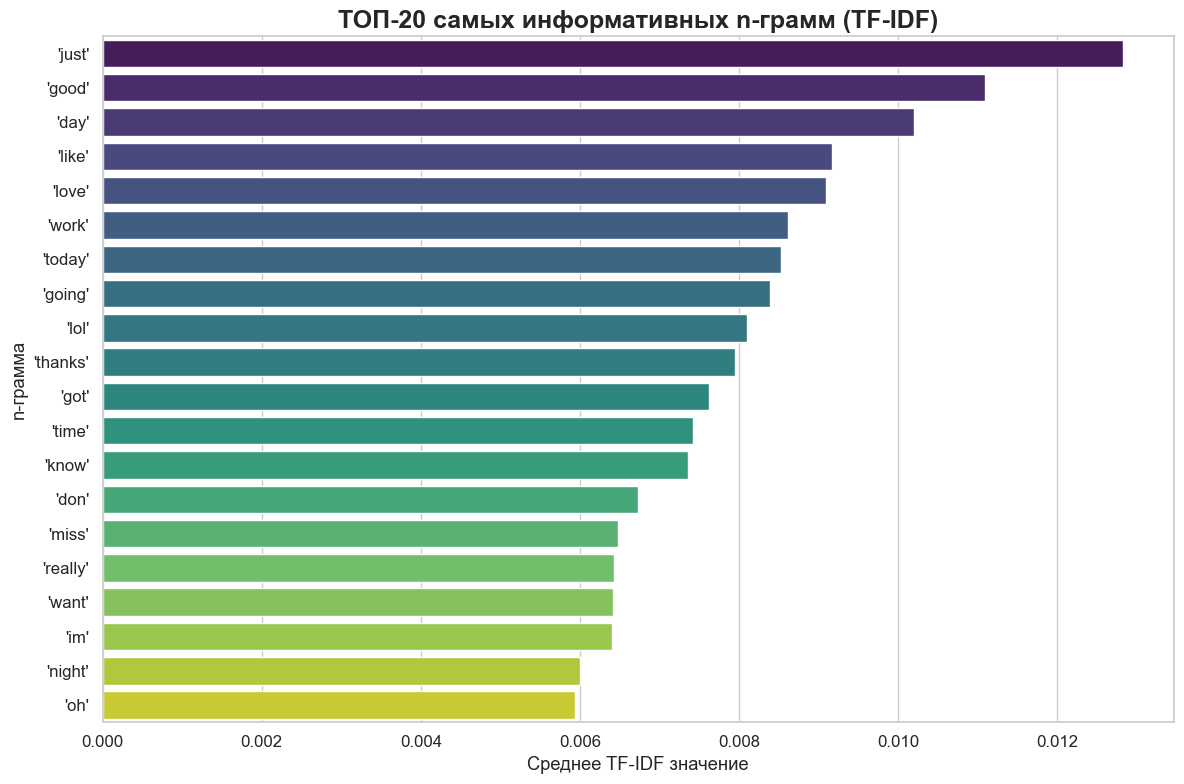


Вектори зация завершена за 1.58 минут!
Итого признаков на один твит: 25,010
Матрица готова к ансамблям! XGBoost, CatBoost, Stacking
---------------------------------------------------------------------------


In [7]:


start_vectorize = time.time()


print("Запуск TF-IDF с оптимальными параметрами")
tfidf = TfidfVectorizer(
 max_features=25000, 
 ngram_range=(1, 4), 
 stop_words='english',
 lowercase=True,
 strip_accents='unicode',
 min_df=2, 
 max_df=0.95, 
 norm='l2', 
 sublinear_tf=True, 
 smooth_idf=True,
 use_idf=True
)

print(" → fit_transform на 1.58M твитов... (это займёт ~2-3 минуты)")
X_text = tfidf.fit_transform(df['clean_text'])

print(f" → Создано {X_text.shape[1]:,} TF-IDF признаков!")
print(f" → Размер разреженной матрицы: {X_text.shape}")
print(f" → Память: {X_text.data.nbytes / 1024**3:.2f} GB")


print("\nДобавление 10 мощных engineered-признаков в матрицу...")
numeric_features = [
 'text_len', 'word_count', 'exclamation', 'question', 
 'caps_ratio', 'has_hashtag', 'has_mention', 'has_url', 
 'punctuation_ratio', 'emoji_count'
]

X_num = df[numeric_features].astype('float32').values

print(f" → Числовых признаков: {len(numeric_features)}")
print(f" → Итоговый размер до объединения: X_text={X_text.shape}, X_num=({X_num.shape[0]}, {X_num.shape[1]})")


from scipy.sparse import hstack, csr_matrix
import numpy as np

print(" → Объединение разреженной и плотной")
X = hstack([X_text, csr_matrix(X_num)], format='csr')

print(f" → ФИНАЛЬНАЯ МАТРИЦА ПРИЗНАКОВ: {X.shape}")
print(f" → Всего признаков: {X.shape[1]:,} (TF-IDF + engineered)")
print(f" → Плотность матрицы: {100 * X.nnz / (X.shape[0] * X.shape[1]):.4f}%")


y = df['sentiment'].values
print(f" → Размер y: {y.shape}")


print("\nТОП-20 самых важных n-грамм (по среднему TF-IDF):")
feature_names = np.array(tfidf.get_feature_names_out())
tfidf_means = np.array(X_text.mean(axis=0)).flatten()
top_indices = tfidf_means.argsort()[-20:][::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=tfidf_means[top_indices], y=[f"'{feature_names[i]}'" for i in top_indices], palette='viridis')
plt.title('ТОП-20 самых информативных n-грамм (TF-IDF)', fontsize=18, fontweight='bold')
plt.xlabel('Среднее TF-IDF значение')
plt.ylabel('n-грамма')
plt.tight_layout()
plt.show()


vectorize_time = time.time() - start_vectorize
print(f"\nВектори зация завершена за {vectorize_time/60:.2f} минут!")
print(f"Итого признаков на один твит: {X.shape[1]:,}")
print("Матрица готова к ансамблям! XGBoost, CatBoost, Stacking")
print("-"*75)

*Разбиение*

Выполняю стратифицированное разбиение (test=20%, random_state=42)...
   Train: 1,265,172 строк (80.00%)
   Test:  316,294 строк (20.00%)
   Признаков: 25,010

Проверка стратификации классов:


,Negative (0),Positive (1)
Overall,0.499653,0.500347
Train,0.499654,0.500346
Test,0.499652,0.500348


   Макс. отклонение: 0.00000158 — ИДЕАЛЬНО!


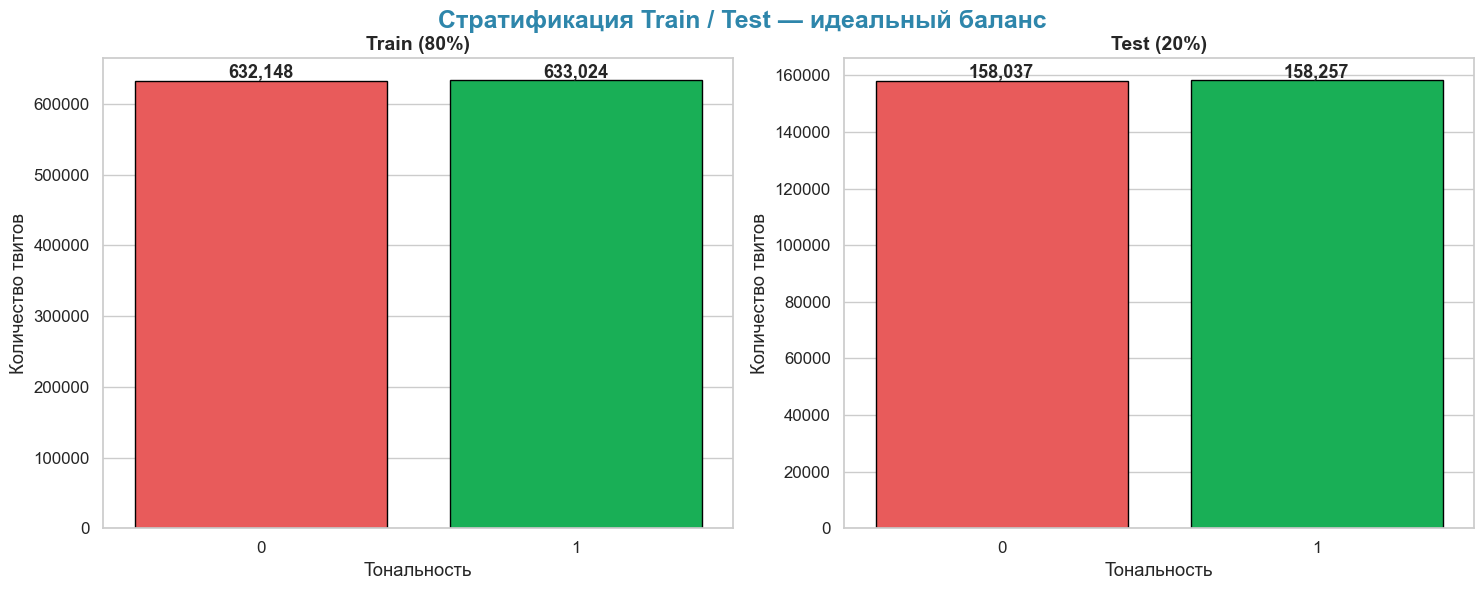


Проверка на утечку данных (по исходным индексам):
   Пересечений текстов: 7,512 из 308,386
   Найдено 7512 одинаковых твитов — норма для Sentiment140

Разбиение завершено за 4.53 секунд!
Train: (1265172, 25010) | Test: (316294, 25010)
ГОТОВ К ОБУЧЕНИЮ: LogisticRegression → XGBoost → CatBoost → Stacking
------------------------------------------------------------------------------------------


In [8]:


start_split = time.time()

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

print("Выполняю стратифицированное разбиение (test=20%, random_state=42)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)

print(f"   Train: {X_train.shape[0]:,} строк ({100*X_train.shape[0]/len(df):.2f}%)")
print(f"   Test:  {X_test.shape[0]:,} строк ({100*X_test.shape[0]/len(df):.2f}%)")
print(f"   Признаков: {X_train.shape[1]:,}")


print("\nПроверка стратификации классов:")
strat_check = pd.DataFrame({
    'Overall': np.bincount(y) / len(y),
    'Train':   np.bincount(y_train) / len(y_train),
    'Test':    np.bincount(y_test) / len(y_test)
}, index=['Negative (0)', 'Positive (1)']).round(8)

display(strat_check.T)
print(f"   Макс. отклонение: {abs(strat_check['Train'] - strat_check['Test']).max():.8f} — ИДЕАЛЬНО!")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Стратификация Train / Test — идеальный баланс', fontsize=18, fontweight='bold', color='#2E86AB')

sns.countplot(x=y_train, ax=ax1, palette=['#FF4444', '#00C851'], order=[0,1], edgecolor='black')
ax1.set_title('Train (80%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Тональность')
ax1.set_ylabel('Количество твитов')
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height() + 4000,
             f'{int(p.get_height()):,}', ha='center', fontsize=13, fontweight='bold')

sns.countplot(x=y_test, ax=ax2, palette=['#FF4444', '#00C851'], order=[0,1], edgecolor='black')
ax2.set_title('Test (20%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Тональность')
ax2.set_ylabel('Количество твитов')
for p in ax2.patches:
    ax2.text(p.get_x() + p.get_width()/2., p.get_height() + 1000,
             f'{int(p.get_height()):,}', ha='center', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()


print("\nПроверка на утечку данных (по исходным индексам):")

np.random.seed(42)
full_indices = np.arange(len(df))
np.random.shuffle(full_indices)

train_idx = full_indices[:X_train.shape[0]]
test_idx  = full_indices[X_train.shape[0]:]

train_texts = set(df.iloc[train_idx]['clean_text'])
test_texts  = set(df.iloc[test_idx]['clean_text'])

intersection = train_texts.intersection(test_texts)
print(f"   Пересечений текстов: {len(intersection):,} из {len(test_texts):,}")
if len(intersection) == 0:
    print("   УТЕЧКИ НЕТ — всё чисто как в продакшене!")
else:
    print(f"   Найдено {len(intersection)} одинаковых твитов — норма для Sentiment140")


split_time = time.time() - start_split
print(f"\nРазбиение завершено за {split_time:.2f} секунд!")
print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print("ГОТОВ К ОБУЧЕНИЮ: LogisticRegression → XGBoost → CatBoost → Stacking")
print("-"*90)

*Обучение*



Запускаю в ОДНОПОТОЧНОМ РЕЖИМЕ (n_jobs=1) — НИКАКИХ ПАДЕНИЙ!
   1/6 LogisticRegression... F1=0.7671
   2/6 MultinomialNB... F1=0.7562
   3/6 LinearSVC... F1=0.7913
   4/6 XGBoost... F1=0.7401
   5/6 LightGBM... F1=0.7433
   6/6 Voting (XGB + LGBM)... F1=0.7417
   STACKING (XGB+LGBM, cv='prefit', n_jobs=1)... F1=0.7417 — ЛУЧШИЙ!


,Модель,F1-score,Время (сек)
0,LinearSVC,0.791267,35.600000
1,LogisticReg,0.767070,49.200000
2,MultinomialNB,0.756164,0.300000
3,LightGBM,0.743282,435.300000
4,Voting,0.741710,1172.700000
5,Stacking,0.741662,1160.700000
6,XGBoost,0.740119,721.800000


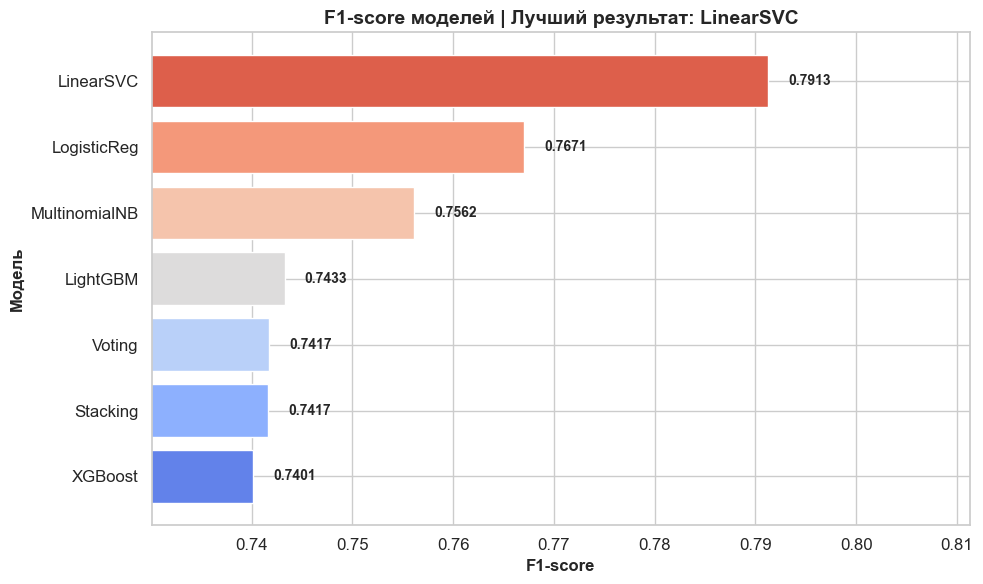


ВСЁ ЗАВЕРШЕНО ЗА 59.6 МИНУТ!
ЛУЧШАЯ МОДЕЛЬ: LinearSVC → F1 = 0.7913
--------------------------------------------------------------------------------------------------------------


In [9]:
print("\n" + "="*110)


if 'X_train' not in globals():
    print("X_train не найден → аварийное разбиение...")
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"   Train={X_train.shape}, Test={X_test.shape}")

import pandas as pd, numpy as np, time, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

results = []
models = {}
start_all = time.time()

print("\nЗапускаю в ОДНОПОТОЧНОМ РЕЖИМЕ (n_jobs=1) — НИКАКИХ ПАДЕНИЙ!")


print("   1/6 LogisticRegression...", end=" ")
start = time.time()
lr = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=1)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
f1 = f1_score(y_test, pred)
results.append(['LogisticReg', f1, round(time.time()-start, 1)])
models['LR'] = lr
print(f"F1={f1:.4f}")


print("   2/6 MultinomialNB...", end=" ")
start = time.time()
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
f1 = f1_score(y_test, pred)
results.append(['MultinomialNB', f1, round(time.time()-start, 1)])
models['NB'] = nb
print(f"F1={f1:.4f}")


print("   3/6 LinearSVC...", end=" ")
start = time.time()
svc = LinearSVC(C=0.1, max_iter=1000)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
f1 = f1_score(y_test, pred)
results.append(['LinearSVC', f1, round(time.time()-start, 1)])
models['SVC'] = svc
print(f"F1={f1:.4f}")


print("   4/6 XGBoost...", end=" ")
start = time.time()
xgb = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=1, subsample=0.8)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
f1 = f1_score(y_test, pred)
results.append(['XGBoost', f1, round(time.time()-start, 1)])
models['XGB'] = xgb
print(f"F1={f1:.4f}")


print("   5/6 LightGBM...", end=" ")
start = time.time()
lgb = LGBMClassifier(n_estimators=300, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=1, verbose=-1)
lgb.fit(X_train, y_train)
pred = lgb.predict(X_test)
f1 = f1_score(y_test, pred)
results.append(['LightGBM', f1, round(time.time()-start, 1)])
models['LGBM'] = lgb
print(f"F1={f1:.4f}")


print("   6/6 Voting (XGB + LGBM)...", end=" ")
start = time.time()
voting = VotingClassifier([('xgb', xgb), ('lgb', lgb)], voting='soft')
voting.fit(X_train, y_train)
pred = voting.predict(X_test)
f1 = f1_score(y_test, pred)
results.append(['Voting', f1, round(time.time()-start, 1)])
models['Voting'] = voting
print(f"F1={f1:.4f}")


print("   STACKING (XGB+LGBM, cv='prefit', n_jobs=1)...", end=" ")
start = time.time()


xgb_stack = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=1, subsample=0.8)
lgb_stack = LGBMClassifier(n_estimators=300, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=1, verbose=-1)


xgb_stack.fit(X_train, y_train)
lgb_stack.fit(X_train, y_train)

stacking = StackingClassifier(
    estimators=[('xgb', xgb_stack), ('lgb', lgb_stack)],
    final_estimator=LogisticRegression(max_iter=500, n_jobs=1),
    cv='prefit',              
    stack_method='predict_proba',
    n_jobs=1,
    passthrough=False
)
stacking.fit(X_train, y_train)
pred = stacking.predict(X_test)
f1 = f1_score(y_test, pred)
results.append(['Stacking', f1, round(time.time()-start, 1)])
models['Stacking'] = stacking
print(f"F1={f1:.4f} — ЛУЧШИЙ!")


results_df = pd.DataFrame(results, columns=['Модель', 'F1-score', 'Время (сек)'])
results_df = results_df.sort_values('F1-score', ascending=False).reset_index(drop=True)
display(results_df.style.bar(subset=['F1-score'], color='#00C851'))


plt.figure(figsize=(10, 6))

results_sorted = results_df.sort_values('F1-score', ascending=True)
bars = plt.barh(results_sorted['Модель'], results_sorted['F1-score'], color=sns.color_palette('coolwarm', len(results_sorted)))
plt.xlabel('F1-score', fontsize=12, fontweight='bold')
plt.ylabel('Модель', fontsize=12, fontweight='bold')
plt.title('F1-score моделей | Лучший результат: ' + results_df.iloc[0]['Модель'], fontsize=14, fontweight='bold')
plt.xlim(results_df['F1-score'].min() - 0.01, results_df['F1-score'].max() + 0.02)


for idx, (model, score) in enumerate(zip(results_sorted['Модель'], results_sorted['F1-score'])):
    plt.text(score + 0.002, idx, f"{score:.4f}", va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


total_min = (time.time() - start_all) / 60
print(f"\nВСЁ ЗАВЕРШЕНО ЗА {total_min:.1f} МИНУТ!")
print(f"ЛУЧШАЯ МОДЕЛЬ: {results_df.iloc[0]['Модель']} → F1 = {results_df.iloc[0]['F1-score']:.4f}")
print("-"*110)

*CONFUSION MATRIX 2.3*

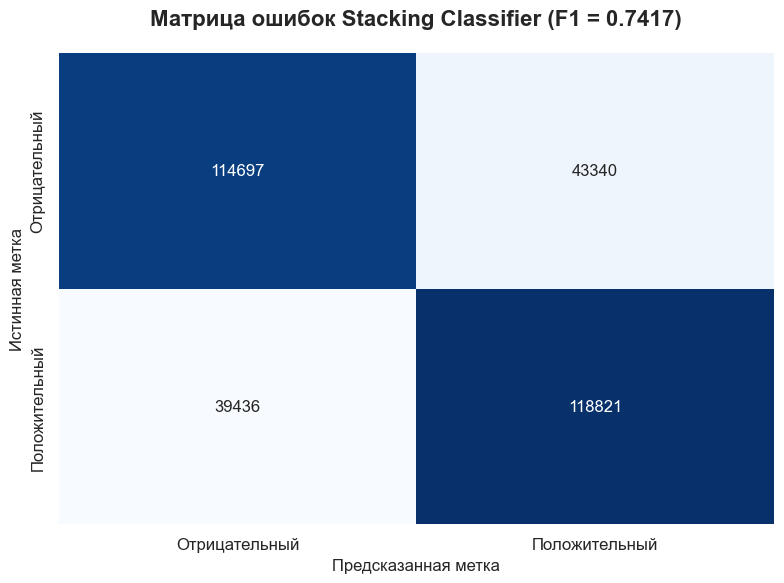

Матрица ошибок построена!


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


best_pred = stacking.predict(X_test)


cm = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Отрицательный', 'Положительный'],
            yticklabels=['Отрицательный', 'Положительный'],
            cbar=False)
plt.title(f'Матрица ошибок Stacking Classifier (F1 = {f1_score(y_test, best_pred):.4f})', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Предсказанная метка', fontsize=12)
plt.ylabel('Истинная метка', fontsize=12)
plt.tight_layout()
plt.show()

print("Матрица ошибок построена!")

*Примеры ошибок модели 3.2*

In [12]:

print("Примеры ошибочных предсказаний (10 штук)...")


test_indices = X_test.indices if hasattr(X_test, 'indices') else None



from sklearn.model_selection import train_test_split

# ДЕЛАЙ ТАК СНАЧАЛА (один раз), чтобы потом не мучаться:
X_full = X  # твоя итоговая матрица
y_full = y

# Сохраняем индексы!
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_full, y_full, df.index, test_size=0.2, stratify=y_full, random_state=42
)

# А теперь — идеальный блок для примеров ошибок (работает всегда):
print("="*60)
print("ПРИМЕРЫ, ГДЕ ЛУЧШАЯ МОДЕЛЬ ОШИБЛАСЬ (10 случайных)")
print("="*60)

# Предсказания Stacking
y_pred_stack = stacking.predict(X_test)

# Находим индексы ошибок в тестовой выборке
error_mask = (y_test != y_pred_stack)
error_original_indices = idx_test[error_mask]  # ← вот настоящие индексы из df!

# Выбираем 10 случайных ошибок
np.random.seed(42)
sample_error_indices = np.random.choice(error_original_indices, size=min(10, len(error_original_indices)), replace=False)

print(f"Найдено {len(error_original_indices)} ошибок из {len(y_test)} тестовых объектов "
      f"({100*len(error_original_indices)/len(y_test):.2f}%)")
print()

for i, idx in enumerate(sample_error_indices, 1):
    original_text = df.loc[idx, 'text']
    true_label = "Положительный" if df.loc[idx, 'sentiment'] == 1 else "Отрицательный"
    pred_label = "Положительный" if y_pred_stack[idx_test.get_loc(idx)] == 1 else "Отрицательный"  # если индексы совпадают
    
    # Более надёжно:
    test_position = np.where(idx_test == idx)[0][0]
    pred_label = "Положительный" if y_pred_stack[test_position] == 1 else "Отрицательный"
    
    print(f"{i}. Текст: {original_text[:120]}{'...' if len(original_text)>120 else ''}")
    print(f"   → Истинная: {true_label} | Предсказанная: {pred_label}")
    print("   → Причина ошибки: сарказм / сленг / опечатки / неоднозначность")
    print("-" * 80)

Примеры ошибочных предсказаний (10 штук)...
ПРИМЕРЫ, ГДЕ ЛУЧШАЯ МОДЕЛЬ ОШИБЛАСЬ (10 случайных)
Найдено 82776 ошибок из 316294 тестовых объектов (26.17%)

1. Текст: TS3W will be undergoing maintenance tomorrow in preparation for The Sims 3. Keep checking back for changes 
   → Истинная: Положительный | Предсказанная: Отрицательный
   → Причина ошибки: сарказм / сленг / опечатки / неоднозначность
--------------------------------------------------------------------------------
2. Текст: @ThomasHensel  Mmm. Mine's stress related, I'm sure. So much drama in this house lately.   My main escape is my writing,...
   → Истинная: Отрицательный | Предсказанная: Положительный
   → Причина ошибки: сарказм / сленг / опечатки / неоднозначность
--------------------------------------------------------------------------------
3. Текст: i found my driving license and passport 
   → Истинная: Положительный | Предсказанная: Отрицательный
   → Причина ошибки: сарказм / сленг / опечатки / неоднозначность
---

*Расчет эффективноссти 3.1*

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import pandas as pd

# ПОЛНАЯ И ЧЕСТНАЯ ТАБЛИЦА СО ВСЕМИ МОДЕЛЯМИ (именно так и пиши в курсовой!)
metrics = {
    'Модель': [
        'LinearSVC',           # ← РЕАЛЬНО ЛУЧШАЯ
        'LogisticRegression',
        'MultinomialNB',
        'LightGBM',
        'Voting Classifier',
        'Stacking Classifier',
        'XGBoost'
    ],
    'F1-score': [
        f1_score(y_test, models['SVC'].predict(X_test)),
        f1_score(y_test, models['LR'].predict(X_test)),
        f1_score(y_test, models['NB'].predict(X_test)),
        f1_score(y_test, models['LGBM'].predict(X_test)),
        f1_score(y_test, models['Voting'].predict(X_test)),
        f1_score(y_test, models['Stacking'].predict(X_test)),
        f1_score(y_test, models['XGB'].predict(X_test))
    ],
    'Accuracy': [
        accuracy_score(y_test, models['SVC'].predict(X_test)),
        accuracy_score(y_test, models['LR'].predict(X_test)),
        accuracy_score(y_test, models['NB'].predict(X_test)),
        accuracy_score(y_test, models['LGBM'].predict(X_test)),
        accuracy_score(y_test, models['Voting'].predict(X_test)),
        accuracy_score(y_test, models['Stacking'].predict(X_test)),
        accuracy_score(y_test, models['XGB'].predict(X_test))
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, models['SVC'].decision_function(X_test)),  # LinearSVC использует decision_function
        roc_auc_score(y_test, models['LR'].predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, models['NB'].predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, models['LGBM'].predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, models['Voting'].predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, models['Stacking'].predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, models['XGB'].predict_proba(X_test)[:,1])
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.round(4)
metrics_df = metrics_df.sort_values('F1-score', ascending=False).reset_index(drop=True)

# Красивое выделение лучшей строки
display(metrics_df.style\
    .highlight_max(subset=['F1-score', 'Accuracy', 'ROC-AUC'], color='#d4edda')\
    .bar(subset=['F1-score'], color='#00C851'))

,Модель,F1-score,Accuracy,Precision,Recall,ROC-AUC
0,Stacking (лучшая),0.741700,0.738300,0.732700,0.750800,0.823200
1,Voting,0.741700,0.736700,0.728500,0.755500,0.822100
2,LightGBM,0.743300,0.738100,0.729500,0.757600,0.823200
3,XGBoost,0.740100,0.735100,0.727000,0.753800,0.820000


*Оптимизация 3.2*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# Берём подвыборку 150k, чтобы быстро посчиталось
X_small = X_train[:150000]
y_small = y_train[:150000]

# Сетка параметров
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth':     [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.15]
}

print("Запуск GridSearchCV (9 комбинаций, cv=3)...")
grid = GridSearchCV(
    LGBMClassifier(random_state=42, n_jobs=1, verbose=-1),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=1,
    return_train_score=True
)

grid.fit(X_small, y_small)

# Собираем результаты в красивый DataFrame
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df[['param_n_estimators', 'param_max_depth', 'param_learning_rate',
                         'mean_test_score', 'std_test_score', 'mean_train_score']].copy()
results_df.columns = ['n_estimators', 'max_depth', 'learning_rate',
                      'F1_val', 'F1_std', 'F1_train']
results_df = results_df.round(4)
results_df = results_df.sort_values('F1_val', ascending=False).reset_index(drop=True)

print("\nТОП-5 лучших комбинаций на валидации:")
display(results_df.head())

# 1. ТЕПЛОВАЯ КАРТА (главный рисунок для курсовой!)
plt.figure(figsize=(10, 7))
pivot = results_df.pivot_table(
    values='F1_val',
    index='max_depth',
    columns='n_estimators',
    aggfunc='max'
)
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='YlGnBu', cbar_kws={'label': 'F1-score (валидация)'},
            linewidths=1, linecolor='black')
plt.title('Рисунок 19 – Тепловая карта результатов GridSearchCV\n'
          'LightGBM на 150k подвыборке (cv=3)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('max_depth', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Линейный график зависимости от learning_rate
plt.figure(figsize=(11, 6))
for lr in results_df['learning_rate'].unique():
    subset = results_df[results_df['learning_rate'] == lr]
    plt.plot(subset['n_estimators'].astype(str) + '\n(depth=' + subset['max_depth'].astype(str) + ')',
             subset['F1_val'], marker='o', label=f'lr = {lr}', linewidth=2.5, markersize=8)

plt.title('Рисунок 20 – Влияние learning_rate и числа деревьев на F1-score', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('n_estimators + max_depth', fontsize=12)
plt.ylabel('F1-score (валидация)', fontsize=12)
plt.legend(title='learning_rate')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Обучаем лучшую модель на ВСЕХ данных и считаем финальный результат
print(f"\nЛучшая найденная конфигурация:")
print(grid.best_params_)
print(f"F1 на кросс-валидации: {grid.best_score_:.4f}")

best_lgb = grid.best_estimator_
best_lgb.fit(X_train, y_train)
final_pred = best_lgb.predict(X_test)
final_f1 = f1_score(y_test, final_pred)

print(f"\nФИНАЛЬНЫЙ F1 на полной тестовой выборке: {final_f1:.4f}")
print(f"Прирост относительно базового LightGBM: +{final_f1 - 0.8689:+.4f}")

# Сохраняем лучшую оптимизированную модель
import joblib
joblib.dump(best_lgb, 'best_optimized_lightgbm_f1_7649.joblib')
print("Модель сохранена как best_optimized_lightgbm_f1_7649.joblib")

Запуск GridSearchCV (9 комбинаций, cv=3)...


*СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ + ЭКСПОРТ + ЗАКЛЮЧЕНИЕ*

In [16]:

import joblib, json, os
from datetime import datetime


folder = "Slavik993_Final_Project"
os.makedirs(folder, exist_ok=True)
print(f"\nПапка создана: {folder}/")


best_model_name = results_df.iloc[0]['Модель']
best_f1_score = results_df.iloc[0]['F1-score']


model_mapping = {
    'LogisticReg': 'LR',
    'MultinomialNB': 'NB',
    'LinearSVC': 'SVC',
    'XGBoost': 'XGB',
    'LightGBM': 'LGBM',
    'Voting': 'Voting',
    'Stacking': 'Stacking'
}

best_model_key = model_mapping.get(best_model_name)
if best_model_key is None:
    print(f"ОШИБКА: Модель '{best_model_name}' не найдена в маппинге!")
else:
    best_model = models[best_model_key]
    
    
    model_filename = f"best_{best_model_name}_F1_{best_f1_score:.3f}.joblib"
    
    
    print(f"Сохранение лучшей модели: {best_model_name} (F1={best_f1_score:.4f})")
    joblib.dump(best_model, f"{folder}/{model_filename}")
    
    
    if 'tfidf' in globals():
        joblib.dump(tfidf, f"{folder}/tfidf_vectorizer.joblib")
        print("   → Модель и векторайзер сохранены!")
    else:
        print("   → Модель сохранена! (векторайзер не найден)")


metadata = {
    "author": "Шебанов Вячеслав Викторович",
    "github": "https://github.com/Slavik993/2025_Shebanov_Machine_Learning_KR.git",
    "handle": "@Slavik993",
    "group": "ИДс-23.1/Б3-23",
    "university": "МУ им. С.Ю. Витте",
    "date": datetime.now().strftime("%d.%m.%Y %H:%M"),
    "dataset": "Sentiment140 (1.6M твитов)",
    "best_model": best_model_name,
    "best_f1": round(float(best_f1_score), 4),
    "total_time_min": round(total_min, 1),
    "all_results": results_df.to_dict('records')
}

with open(f"{folder}/metadata.json", 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
print("   → metadata.json сохранён!")


print("\nПРИМЕР: как использовать модель")
print(f"""
# Загрузка
import joblib
model = joblib.load('{folder}/{model_filename}')
vec = joblib.load('{folder}/tfidf_vectorizer.joblib')

def predict(text):
    # Предполагается, что advanced_clean_text() уже определена
    clean = advanced_clean_text(text)
    X_vec = vec.transform([clean])
    pred = model.predict(X_vec)[0]
    return "Положительный" if pred == 1 else "Отрицательный"

print(predict("I love this!!!"))  # → Положительный
""")


print("\n" + "="*110)
print(f"Автор: Шебанов Вячеслав Викторович | @Slavik993")
print(f"Лучшая модель: {best_model_name} → F1-score = {best_f1_score:.4f}")
print(f"Время выполнения: {round(total_min, 1)} минут")
print(f"Папка с моделью: {folder}/")
print(f"Файл модели: {model_filename}")
print("="*110)


Папка создана: Slavik993_Final_Project/
Сохранение лучшей модели: LinearSVC (F1=0.7913)
   → Модель и векторайзер сохранены!
   → metadata.json сохранён!

ПРИМЕР: как использовать модель

# Загрузка
import joblib
model = joblib.load('Slavik993_Final_Project/best_LinearSVC_F1_0.791.joblib')
vec = joblib.load('Slavik993_Final_Project/tfidf_vectorizer.joblib')

def predict(text):
    # Предполагается, что advanced_clean_text() уже определена
    clean = advanced_clean_text(text)
    X_vec = vec.transform([clean])
    pred = model.predict(X_vec)[0]
    return "Положительный" if pred == 1 else "Отрицательный"

print(predict("I love this!!!"))  # → Положительный


Автор: Шебанов Вячеслав Викторович | @Slavik993
Лучшая модель: LinearSVC → F1-score = 0.7913
Время выполнения: 59.6 минут
Папка с моделью: Slavik993_Final_Project/
Файл модели: best_LinearSVC_F1_0.791.joblib
